SPI bus issues:


We accidently bought some SPI bus sensors.  The example code conflicts with the SD card reader/writer on the datalogger shields. 

I went round and round with this sensor/datalogger problem.  I found a solution, though I am amazed that it worked (and not entirely sure why it works).  The problem is that the SPI data bus on an Arduino requires four wires in addition to 5V and GND.  For the SD card reader/writer on the datashield those wires are built into pins 10, 11, 12, and 13. We can’t change those.  And for the SPI bus all the data lines for all devices on the bus are supposed to share three of the four wires.  So I chose the CS wire that is supposed to be unique to pin #7.  But this did not work.  So I read a lot and tried other pins and considered adding some additional separation hardware.  But I noticed that the Arduino UNO has a lot of flexibility in its digital pins.  So I tried moving both the sensor transmit and receive to pins 6 and 7 (RX = 7 and TX = 6).  And it worked.  I copied my code that worked below.  I checked both the serial monitor and the SD card data.  They look good and reasonable (and importantly—they match!). 


In [ ]:
// ===================================================
// Datalogger code for the 
// Gravity UART Infrared Carbon Dioxide Sensor
// Based on the example code from DFrobot found
// at https://wiki.dfrobot.com/Infrared_CO2_Sensor_0-50000ppm_SKU__SEN0220
// 
// R. T. Lines
// Last revised: 2023-6-26
//
// To resolve conflicts between the SD card and the sensor on the 
//    SPI bus I moved the TX and RX pins for the sensor to 
//    pins RX = 7 and TX = 6 so they are far away from the pins
//    10, 11, 12, and 13 used by the SD card reader/writer.
//
// Based on the RobotDyn SD/RTC Arduino shield example
//    Meant to serve as a starting point for data logging
//    using both a real-time clock (RTC) and a microSD 
//    card.
//
// Collects data at a given rate, that is set by the
//   delay at the end of the loop with the delay time in 
//   milliseconds.  
//
// This code uses the strategy of opening the file, 
//   writing data, and closing the file for each data 
//   point so if the sensor fails the file will fail 
//   having just been closed and only the last data 
//   point will be lost. It does not warn you if the 
//   data file won't open so be sure to check that data 
//   is actually being written to your SD card.
//
//   The code uses a RTC for it's time stamp.    
//   
// ===================================================


// ==== include statements
   #include <SD.h>  


// RTC libary by Adafruit. Must be manually installed
   #include "RTClib.h" 

// BME680 libaries by Adafruit.
  #include <SPI.h>


// SD card pin to use
   const int SD_PIN = 10;


// Real time clock type and variable
   RTC_DS1307 rtc;

// Gravity UART Infrared Carbon Dioxide Sensor
// Library and variables
   #include <SoftwareSerial.h>
   // change the pins so no conflict with the SD card reader
   SoftwareSerial mySerial(7, 6); // RX, TX
   //Read the gas density command /Don't change the order
   unsigned char hexdata[9] = {0xFF,0x01,0x86,0x00,0x00,0x00,0x00,0x00,0x79}; 
   // now a place to put the C02 data 
   String CO2_String = "";

// My functions:

// =========================================
// initializes the RTC, 
// and checks to see if it has been set
// =========================================
void init_RTC() {
  Serial.print("Initializing RTC...");
  //
  if (!rtc.begin()) {
    Serial.println(" failed!");
    while (1);
  }
  //
  Serial.println(" done!");
  //
  if (!rtc.isrunning())
    Serial.println(
    "WARNING: RTC has not been previously set");
  }


// ======================================================
// attempts to initialize the SD card for reading/writing
// ======================================================


void init_SD() {
  Serial.print("Initializing SD card...");
  //
  if (!SD.begin(SD_PIN)) {
    Serial.println(" failed!");
    while (1);
    }
  //
  Serial.println(" done!");
  }


// ====================================================
// SETUP
// ====================================================

void setup() {
   // Open serial communications for the serial monitor
      Serial.begin(9600);

   // Start the real time clock. This is from the 
   //     Adafruit RTC example code since our data
   //     loggers use Adafruit RTS's

      init_RTC();
         // (note 24-hour time: 3pm -> 15)	
         // This line sets the RTC with an 
         // explicit date & time, for example: 
         // to set January 21, 2014 at 3:18pm 
         // you would use the following line: 
         // rtc.adjust(DateTime(2023, 4, 27, 17, 05, 0));

   // Initialize the SD card so we can write to it in
   //   the loop
      init_SD();

   
  // Now set up your sensor here.  
     mySerial.begin(9600);  
  

 // Tell the User that we started a new collection
    //  Be careful here. Printing things in the setup can be
    //  tricky. Don't print something that is very long
    File dataFile = SD.open("datalog.txt", FILE_WRITE);
       dataFile.println("START OF NEW COLLECT");
       Serial.println("START OF NEW COLLECT");
       dataFile.close();

  }  // End of setup


// ====================================================
// LOOP
// ====================================================
  
void loop( ) {
  // make a place to put our time stamp and data
  String dataString="";
  //
  // get the time stamp information from the RTC
  DateTime now = rtc.now();
  //
  // make an output string that has the time and date
  //    We need to be careful while doing this.
  //    Arduino Unos have only a tiny bit of memory
  //    It is really easy to use it all up and when
  //    we do, the microcontroller can become 
  //    unstable. We have three devices connected
  //    to our Arduino, the SD card reader, the RTC
  //    and the sensor. That is a lot!  So we will output 
  //    the data with as few extra characters as 
  //    possible. This includes spaces! We will 
  //    separate using commas, because python
  //    makes it easy to use csv files.  I left 
  //    in units, but you could put them in the 
  //    headder and reduce the dataString further.
  dataString = dataString + String(now.year());
  dataString = dataString + '-' ;
  dataString = dataString + String(now.month());
  dataString = dataString + '-';
  dataString = dataString  + String(now.day());
  dataString = dataString + ' ';
  dataString = dataString  + String(now.hour());
  dataString = dataString + ":";
  dataString = dataString  + String(now.minute());
  dataString = dataString + ":";
  dataString = dataString  + String(now.second());
  //dataString = dataString + ",";

  // Now get the sensor data

   mySerial.write(hexdata,9);
   delay(500);

   for(int i=0,j=0;i<9;i++) {
      if (mySerial.available()>0) {
         long hi,lo,CO2;
         int ch=mySerial.read();
         if(i==2){     hi=ch;   }   //High concentration
         if(i==3){     lo=ch;   }   //Low concentration
         if(i==8) {
               CO2=hi*256+lo;  //CO2 concentration
               //Serial.print(dataString);
               //Serial.print(" cO2 concentration: ");
               //Serial.print(CO2);
               //Serial.println("ppm");
               CO2_String = String(CO2);
               }
         }
   }

   // Add the sensor data to the output string
   dataString = dataString + ","+CO2_String+" ppm";

  // Print the time stamp and data to the serial monitor
  Serial.println(dataString);

  // Print the time stamp and data to the SD Card
  File dataFile = SD.open("datalog.txt", FILE_WRITE);
     dataFile.println(dataString);
     dataFile.close();
  //

  delay(1000); // time between data points
  
  // End of Loop
  }

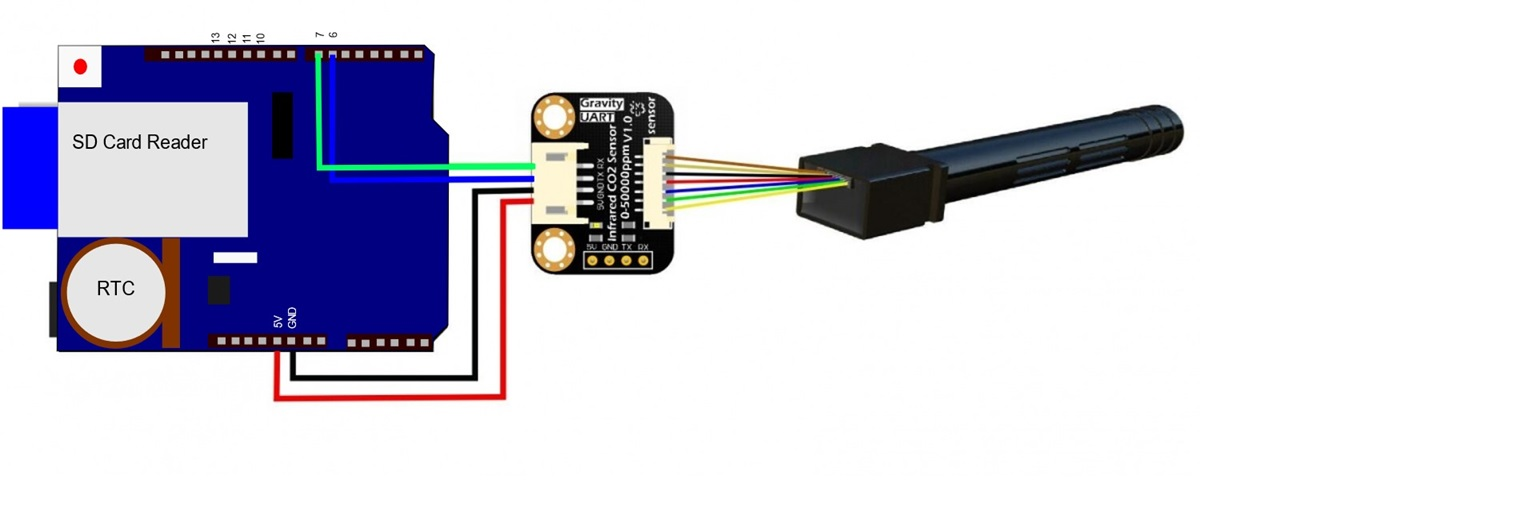

The new Co2 sensors are not SPI!!! they are UART.  That is why they worked.  There is a nice description of UART at https://www.circuitbasics.com/basics-uart-communication/.  It is the old printer/mouse serial communications with packatized data so you don't need a clock line to syncronize the data transfer.  This is why the sensor worked.  Because the Ardunio digital pins can use UART, any two digital pins will work.  So we just needed to move the sensor connection away from the SD card SPI bus connections on pins 10-13.  Then all was well. Like a printer cable, the UART is nto a bus and won't allow more than one sensor on the UART pins you choose.  But since we have enough digital pins on the Arduino, this works fine for our CO2 sensor and Datalogger shield.